<a href="https://colab.research.google.com/github/oziboran123/emotion-analysis-from-sentences/blob/main/AI_Project_NLP_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#GEREKLİ KÜTÜPHANELERİN İMPORT EDİLMESİ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import warnings
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.multiclass import  OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from tensorflow import keras
import tensorflow as tf
import os.path
from keras.models import load_model
import pickle
import neattext.functions as nfx

In [11]:
pip install neattext

     |████████████████████████████████| 114 kB 3.1 MB/s 


In [2]:
#VERİ SETİNİN DOSYAYA DAHİL EDİLMESİ
veri = pd.read_csv('emotion_dataset.csv')
print(veri.head())

   Emotion                                               Text
0  neutral                                             Why ? 
1      joy    Sage Act upgrade on my to do list for tommorow.
2  sadness  ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3      joy   Such an eye ! The true hazel eye-and so brill...
4      joy  @Iluvmiasantos ugh babe.. hugggzzz for u .!  b...


In [6]:
#ETİKETLERİN İNCELENMESİ VE DEĞİŞKENLERE ATANMASI
etiketler = Counter(veri['Emotion']).keys()
etiket_sayilari = Counter(veri['Emotion']).values()

dict_keys(['neutral', 'joy', 'sadness', 'fear', 'surprise', 'anger', 'shame', 'disgust'])
dict_values([2254, 11045, 6722, 5410, 4062, 4297, 146, 856])


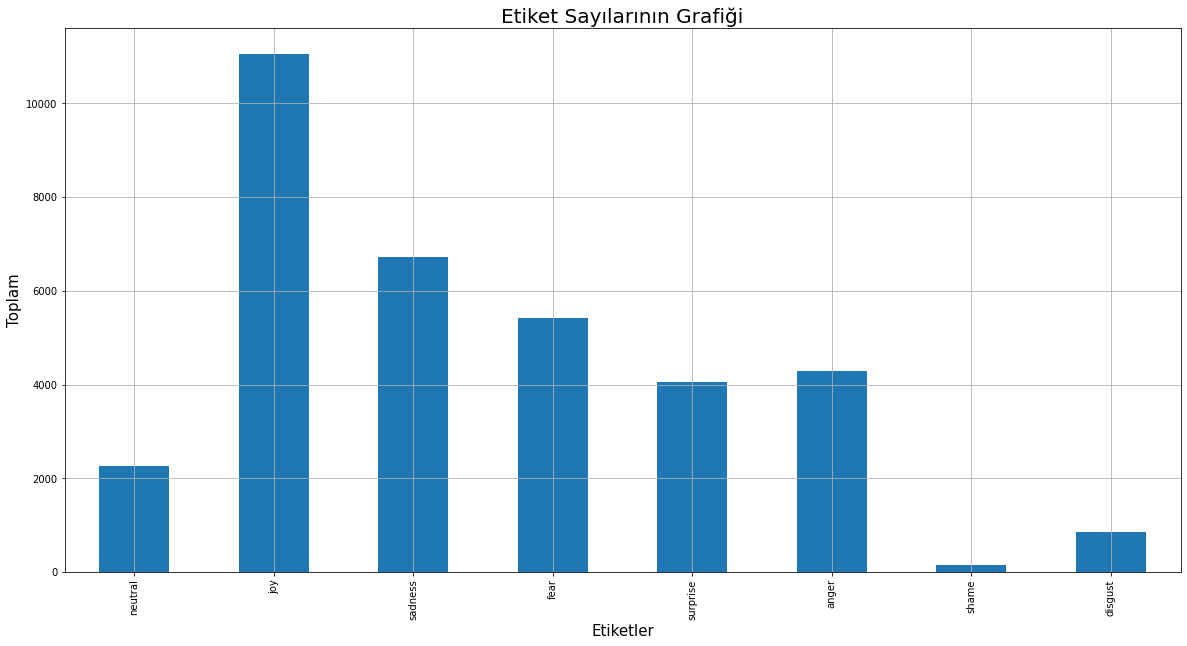

In [7]:
#ETİKETLERİN GÖRSELLEŞTİRİLMESİ
etiket_df = pd.DataFrame(zip(etiketler,etiket_sayilari),columns = ['Sınıf','Toplam'])
etiket_df.plot(x = "Sınıf", y= "Toplam", kind = "bar", legend = False, grid = True, figsize = (20,10))
plt.title("Etiket Sayılarının Grafiği",fontsize = 20)
plt.xlabel("Etiketler",fontsize = 15)
plt.ylabel("Toplam",fontsize = 15)
plt.show()

In [17]:
#VERİNİN ÇÖP KELİMELERDEN AYRILMASI
veri['Text'] = veri['Text'].apply(nfx.remove_userhandles)
veri['Text'] = veri['Text'].apply(nfx.remove_stopwords)
print(veri.head())

   Emotion                                               Text  \
0  neutral                                                  ?   
1      joy                    Sage Act upgrade list tommorow.   
2  sadness  WAY HOMEGIRL BABY FUNERAL!!! MAN HATE FUNERALS...   
3      joy  eye ! true hazel eye-and brilliant ! Regular f...   
4      joy  ugh babe.. hugggzzz u .! babe naamazed nga ako...   

                                          Clean_Text  
0                                                  ?  
1                    Sage Act upgrade list tommorow.  
2  WAY HOMEGIRL BABY FUNERAL!!! MAN HATE FUNERALS...  
3  eye ! true hazel eye-and brilliant ! Regular f...  
4  ugh babe.. hugggzzz u .! babe naamazed nga ako...  


In [19]:
#VERİNİN AYIRLIMASI İŞLEMİ
veritext = veri['Text']
veritag = veri['Emotion']


In [30]:
#X LER EĞİTİM VE TESTTE KULLANILACAK CÜMLELER Y LER İSE ETİKETLER
#EĞİTİM VE TEST OLARAK AYIRLIMASI
x_egitim,x_test,y_egitim,y_test = train_test_split(veritext, veritag, test_size = 0.25, random_state = 42)

In [31]:
#SKORLAMA İŞLEMİ
tfidf_vektor = TfidfVectorizer(ngram_range= (1,2) ,max_df=0.9, min_df = 5)
x_egitim_tfidf = tfidf_vektor.fit_transform(x_egitim)
x_test_tfidf = tfidf_vektor.transform(x_test)
print(x_egitim_tfidf)

  (0, 2142)	0.5803781862777663
  (0, 4522)	0.4555405475025381
  (0, 6146)	0.34998847090365104
  (0, 2062)	0.38953780268615823
  (0, 2141)	0.4259252762950119
  (1, 5004)	1.0
  (2, 1872)	1.0
  (3, 3049)	0.41475898039402015
  (3, 2663)	0.40027580676083396
  (3, 5574)	0.29279537274955386
  (3, 3044)	0.28618313531745326
  (3, 3532)	0.41688853532867565
  (3, 89)	0.4414071449588251
  (3, 4081)	0.27198031336034567
  (3, 2652)	0.23982230942098967
  (4, 4527)	0.5727658907353876
  (4, 5138)	0.44706815971066993
  (4, 1138)	0.3650987542867388
  (4, 2068)	0.42871620252725456
  (4, 4523)	0.39366814995868576
  (5, 2348)	0.4969112909586468
  (5, 4584)	0.47474639363625176
  (5, 4037)	0.48471306772283973
  (5, 2347)	0.4590201487143669
  (5, 6618)	0.2864415746712379
  :	:
  (26088, 6911)	0.2288221514100699
  (26088, 6430)	0.28281286109877796
  (26088, 6127)	0.20856854716484755
  (26089, 5850)	0.5173034147904951
  (26089, 284)	0.5638950996526333
  (26089, 1469)	0.46635441756694923
  (26089, 2627)	0.3331018

In [32]:
#MODELİN EĞİTİLMESİ
sgd_model = OneVsRestClassifier(SGDClassifier(loss="hinge", penalty="elasticnet", max_iter = 50))
sgd_model.fit(x_egitim_tfidf,y_egitim)
print(sgd_model)

OneVsRestClassifier(estimator=SGDClassifier(max_iter=50, penalty='elasticnet'))


In [33]:
#BAŞARI ORANI GÖZLENMESİ
print(sgd_model.predict(x_test_tfidf))
print(accuracy_score(y_test,sgd_model.predict(x_test_tfidf)))

['fear' 'anger' 'sadness' ... 'sadness' 'joy' 'sadness']
0.6111749827546562


In [34]:
#MODELİN KAYDEDİLMESİ
with open("sgd_model.pkl","wb") as i:
  pickle.dump(sgd_model,i)

In [29]:
#MODELİN BAŞKA DOSYADA KULLANILMASI
import pickle
with open("sgd_model.pkl","rb") as j:
  model = pickle.load(j)
print(model)

OneVsRestClassifier(estimator=SGDClassifier(max_iter=50, penalty='elasticnet'))
